## Import relevant packages

In [20]:
import sys
sys.path.append("..")
import STWave
from STWave.measure import measure_resources
import scanpy as sc

## Read data

In [21]:
data_path = '/home/guo/jt/data/bighumanbreast/bighumanbreast.h5ad'
adata =sc.read_h5ad(data_path)

## Data preprocess

In [22]:
adata_raw = adata.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=adata.shape[1])
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Construct spatial networks and pruning networks

In [23]:
STWave.Cal_Spatial_Net(adata,k_cutoff=8)
STWave.Cal_Precluster_Net(adata,is_pca=False,verbose=True,res_pre=0.5)

------Calculating spatial graph...
Spatial graph contains 1342240 edges, 167780 cells.
8.0000 neighbors per cell on average.
Spatial graph calculation time: 1.55 seconds
------Calculating precluster graph...
Precluster spatial graph contains 739545 edges, 167780 cells.
4.4078 neighbors per cell on average.
Precluster graph calculation time: 44.50 seconds


## Train the STWave model
 ```STWave.Trainer()``` Args
 - dim_reduction (str, optional): Dimensional reduction method ('PCA', 'HVG', or None). Defaults to 'PCA'.
 - batch_data (bool, optional): Whether to split data into batches for training, defaults to False.
 - num_batch_x_y (Tuple[int, int], optional): Number of batches along x and y axes if batch_data=True, defaults to None.
 - device ('cuda', 'cpu'): 'cuda' or 'cpu'.

In [24]:
trainer = STWave.Trainer(adata,dim_reduction='HVG',batch_data=True,num_batch_x_y=[4,4],device='cuda')
adata

check PyG Data object device：

x: shape=(167780, 313), device=cpu, dtype=torch.float32
edge_index: shape=(2, 2417345), device=cpu, dtype=torch.int64
edge_type: shape=(2417345,), device=cpu, dtype=torch.int64
------Using device: cuda:0
------Using default weights:  {'w_recon': 1, 'w_wave': 20}
------calculating batch indices...


100%|██████████| 16/16 [00:00<00:00, 3546.79it/s]


------sampling subgraphs...


100%|██████████| 16/16 [00:00<00:00, 55.84it/s]


AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'ensemble_id', 'type', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial'

```Trainer.train()``` Args
- hidden_dims (List[int], optional): Hidden dimensions for STWaveNet, defaults to [100, 32].
- n_epochs (int, optional): Number of training epochs, defaults to 200.
- save_reconstrction (bool, optional): If True, saves reconstructed data in adata.obsm, defaults to True.

In [25]:
@measure_resources
def train():
    trainer.train(hidden_dims=[100,32],n_epochs=200,save_reconstrction=True)
train()
adata

using wavelet: db4
deconposing levels: 3
------training batch...


100%|██████████| 200/200 [03:30<00:00,  1.05s/it, _1loss=11.5, _2loss_recon=3.1, _3loss_wave=0.422] 


------inferencing...


100%|██████████| 16/16 [00:00<00:00, 19.38it/s]


------saving embeddings...
------saving reconstrction...

RESOURCE USAGE REPORT
timestamp                     : 2025-10-28 23:06:48
function_name                 : train
execution_time_minutes        : 3.5341
execution_time_seconds        : 212.05
memory_usage_gb               : 6.07
gpu_memory_allocated_gb       : 0.22
gpu_memory_cached_gb          : 4.25
cuda_available                : True



AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'ensemble_id', 'type', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'STWave', 'STWave_ReX'

In [26]:
adata_raw,adata

(AnnData object with n_obs × n_vars = 167780 × 313
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
     var: 'ensemble_id', 'type'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 167780 × 313
     obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
     var: 'ensemble_id', 'type', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'Spatial_Net', 'Precluster_Net'
     obsm: 'spatial', 'STWave', 'STWave_ReX')

In [27]:
adata.X = adata.obsm['STWave_ReX']

## Spatial representation visualization

In [28]:
gene = 'ERBB2'

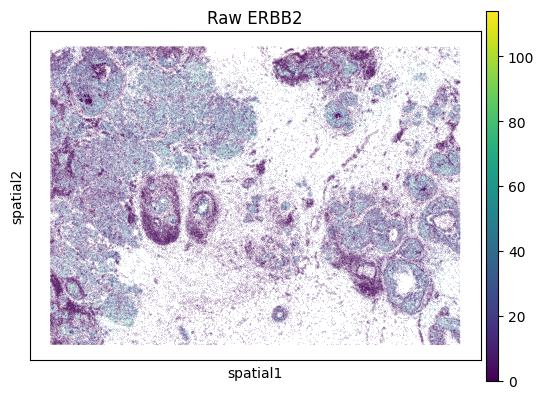

In [29]:
sc.pl.spatial(adata_raw, img_key=None,color=gene, spot_size=10, title='Raw '+gene)

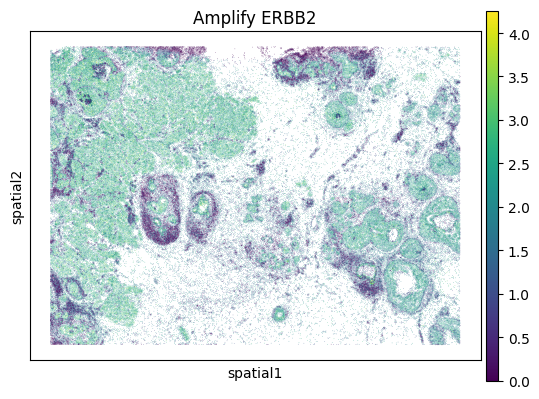

In [30]:
sc.pl.spatial(adata, img_key=None,color=gene, spot_size=10, title='Amplify '+gene)